# Load Data

In [2]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import json
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import lxml

2024-10-17 07:55:47.258970: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-17 07:55:47.273538: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-17 07:55:47.277878: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-17 07:55:47.289431: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-17 07:55:48.418855: W tensorflow/compiler/tf2

In [3]:
LOWER_MEKONG_STATION_CODES =  [
    "STR", # StungTreng
    "KRA", # Kratie
    "KOM", # Kompong Cham
    "PPB", # Phnom Penh (Bassac)
    "PPP", # Phnom Penh Port
    "KOH", # Koh Khel (Bassac)
    "NEA", # Neak Luong
    "PRE", # Prek Kdam (Tonle Sap)
    "TCH", # Tan Chau
    "CDO", # Chau Doc (Bassac)
]
BASE_URL = "http://ffw.mrcmekong.org/fetchwet_st.php?StCode="
r = requests.get(BASE_URL+LOWER_MEKONG_STATION_CODES[3], verify=False)
# soup = BeautifulSoup(r.content, 'html5lib')
# body = soup.find('body')
data_string = r.content.decode('utf-8')

# Convert single quotes and remove any non-JSON parts
data_string = data_string.replace('date_gmt:', '"date_gmt":')
data_string = data_string.replace('Max:', '"Max":')
data_string = data_string.replace('Min:', '"Min":')
data_string = data_string.replace('AVG:', '"AVG":')
data_string = data_string.replace('floodLevel:', '"floodLevel":')
data_string = data_string.replace('alarmLevel:', '"alarmLevel":')
for year in range(1992, 2025):
    data_string = data_string.replace(f'{year}:', f'"{year}":')

data_string = data_string.replace(',]', ']')

# Now parse it into a list of dictionaries
data = json.loads(data_string)

# Convert to dataframe
df = pd.DataFrame(data)
df['date_gmt'] = df['date_gmt'].apply(lambda x: x.split("-")[1]+"-"+x.split("-")[2])
df['station'] = LOWER_MEKONG_STATION_CODES[3]

# Set date_gmt as index 
df.index = df['date_gmt']

df.describe()

/home/vscode/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ffw.mrcmekong.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


,Max,Min,AVG,1992,1998,2000,2016,2017,2018,2019,2020,2021,2022,2023,2024,floodLevel,alarmLevel
count,153.000000,153.0,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.0,153.0
mean,9.479281,0.0,7.140654,6.269608,5.489020,9.092484,5.459869,7.036275,7.262484,4.709412,4.009477,4.709281,6.199608,5.300261,4.926667,12.0,10.5
std,1.792758,0.0,2.184002,2.262871,1.771895,1.952256,2.049587,1.856611,2.555734,2.435415,1.792308,1.689127,2.031904,2.354565,2.864221,0.0,0.0
min,4.900000,0.0,2.690000,2.040000,2.420000,4.700000,1.940000,3.550000,2.590000,1.990000,1.640000,1.760000,3.240000,0.000000,0.000000,12.0,10.5
25%,8.240000,0.0,5.290000,4.400000,4.760000,7.620000,4.150000,4.670000,4.190000,2.420000,2.270000,3.220000,3.840000,2.670000,2.150000,12.0,10.5
50%,10.390000,0.0,8.140000,6.910000,5.810000,9.760000,5.640000,8.130000,8.140000,4.070000,4.170000,4.730000,6.790000,6.280000,6.260000,12.0,10.5
75%,10.770000,0.0,9.000000,8.340000,6.870000,10.490000,7.420000,8.440000,9.600000,6.630000,5.360000,6.380000,7.840000,7.430000,7.100000,12.0,10.5
max,11.200000,0.0,9.450000,9.010000,7.920000,11.200000,8.130000,8.860000,9.950000,9.490000,7.700000,7.560000,9.220000,8.260000,9.100000,12.0,10.5


# Preprocess

<Axes: xlabel='DATE_GMT'>

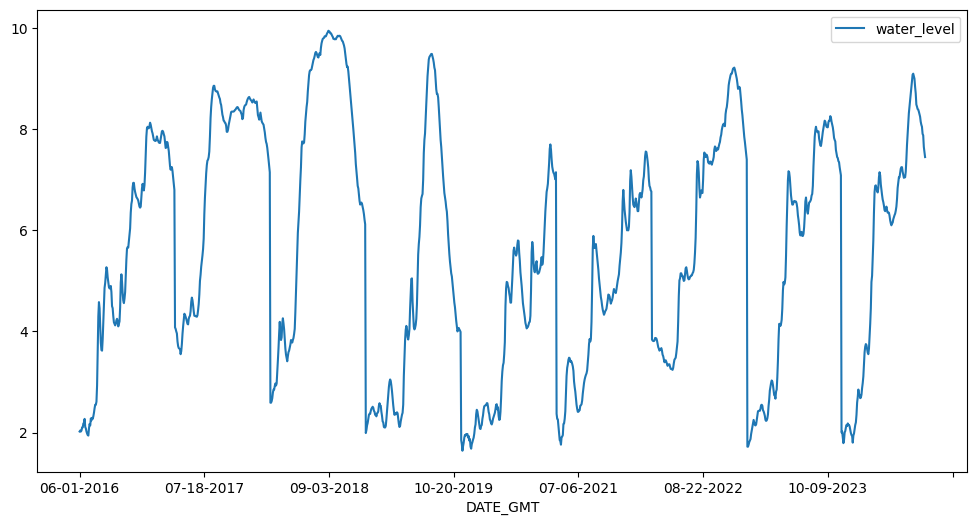

In [4]:
df_filtered = df[['date_gmt', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']]
df_filtered.set_index('date_gmt', inplace=True)
df_filtered.reset_index(inplace=True)
df_long = pd.melt(df_filtered, id_vars=['date_gmt'], value_vars=['2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024'],
                   var_name='Year', value_name='water_level')
df_long['DATE_GMT'] = pd.to_datetime(df_long['date_gmt'] + '-' + df_long['Year'], format='%m-%d-%Y').dt.strftime('%m-%d-%Y')
df_long = df_long[['DATE_GMT', 'water_level']]
df_non_zero = df_long[df_long['water_level'] != 0]
df_non_zero.set_index('DATE_GMT', inplace=True)
df_non_zero.index.freq='D'
df_non_zero.plot(figsize=(12,6))

# Train

In [5]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

# Split 2016-2024 For Training 2024-End for testing
train = df_non_zero.iloc[:1222]
test = df_non_zero.iloc[1222:]

# Scale the data
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)  # Fit on train and transform both train and test
scaled_test = scaler.transform(test)

look_back = 10  # Number of previous time steps to consider for prediction
batch_size = 32  # Batch size

# Create TimeseriesGenerator for training and testing data
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=look_back, batch_size=batch_size)
test_generator = TimeseriesGenerator(scaled_test, scaled_test, length=look_back, batch_size=batch_size)

In [6]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(look_back, scaled_train.shape[1])))
model.add(Dense(scaled_train.shape[1]))
model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(train_generator, 
                    epochs=100, 
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/100


/home/vscode/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2895
Epoch 2/100
 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0378

/home/vscode/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/home/vscode/.local/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0546
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0165
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0109
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 
Epoch 15/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034    
Epoch 16/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052   
Epoch 1

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1523e-04 


Test Loss: 0.00030699200578965247
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


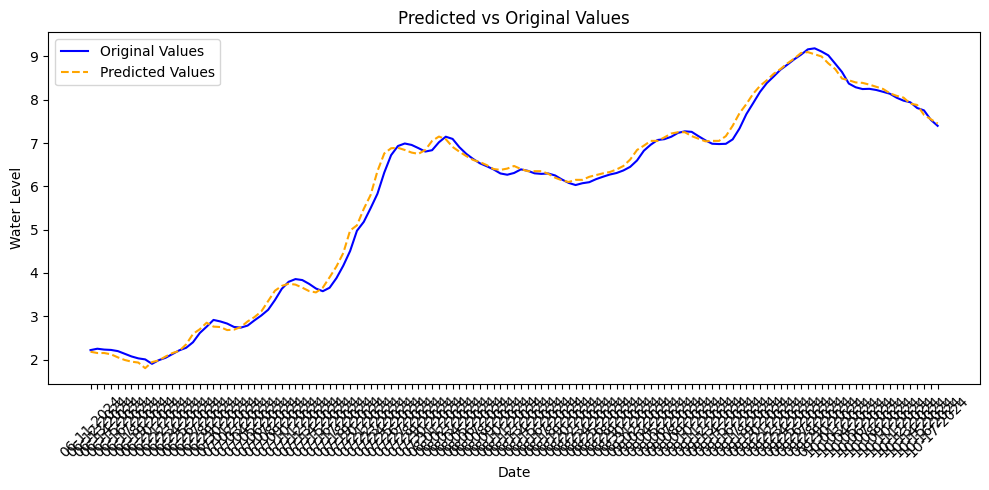

In [11]:
# Evaluate the model on test data
loss = model.evaluate(test_generator)
print(f"Test Loss: {loss}")

# Make predictions
predictions = model.predict(test_generator)

# Inverse scale predictions to original values
predictions_inverse = scaler.inverse_transform(predictions)
test_data = scaled_test[look_back:]

# Inverse scale the predictions and test data to get back the original scale
predictions_inverse = scaler.inverse_transform(predictions)
original_test_data_inverse = scaler.inverse_transform(test_data)

test_dates = df_non_zero.index[1222 + look_back:1222 + len(predictions) + look_back]

# Plot predicted vs original values with dates
plt.figure(figsize=(10, 5))
plt.plot(test_dates, original_test_data_inverse, label='Original Values', color='blue')
plt.plot(test_dates, predictions_inverse, label='Predicted Values', linestyle='dashed', color='orange')
plt.title('Predicted vs Original Values')
plt.xlabel('Date')
plt.ylabel('Water Level')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.legend()
plt.tight_layout()
plt.show()
